In [ ]:
#| default_exp analytics

# Analytical functions

In [ ]:
#| export
import numpy as np

In [ ]:
#| hide
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Step length distribution generators

In [ ]:
#| export
def pdf_multimode(L: int, # Either int or array for which pdf is calculated
                  lambdas: list, # Scales of each modes
                  probs: list # Probability weight of each mode
                 )-> np.array: # Array with probability of each L
    '''  Computes the discrete PDF of multi-mode exponential of the form
    
    $$
    \Pr(L) = \sum_{i=1,2} \omega_i (1-e^{-1/\lambda_i}) e^{-(L-1)/\lambda_i} \, ,
    $$
    where $\omega$ is the probability of each mode and $\lambda$ it's scale.
    
    '''
    if isinstance(L, int):
        return np.sum((probs)*(np.exp(1/lambdas)-1)*np.exp(-L/lambdas))
    else:
        return [np.sum((probs)*(np.exp(1/lambdas)-1)*np.exp(-l/lambdas)) for l in L]
        

Text(0, 0.5, 'P(L)')

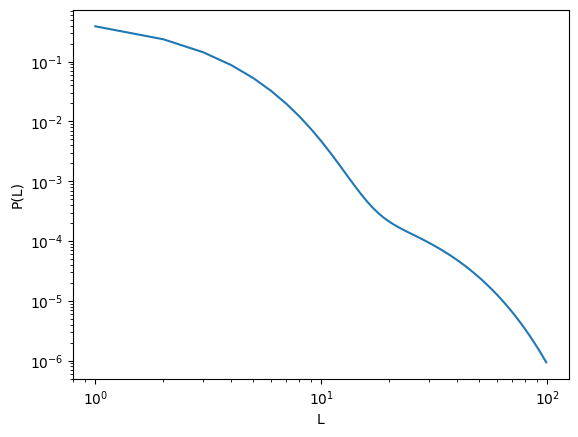

In [ ]:
lambdas = np.array([2,15])
probs = np.array([0.99, 0.01])
L_max = 100
plt.loglog(np.arange(1, L_max),
           pdf_multimode(L = np.arange(1, L_max), lambdas=lambdas, probs=probs)
          )
plt.xlabel('L'); plt.ylabel('P(L)')

In [ ]:
#| export
from scipy.special import zeta

def pdf_powerlaw(L:float, # Either int or array for which pdf is calculated
                 beta: float = 1, # Exponent of the power law
                )-> np.array : # Array with probability of each L
    ''' Computes the discrete PDF of a powerlaw of the form 
    $$
    \Pr(L)\sim L^{-1-\mathrm{beta}}.
    $$
    '''
    if not isinstance(L, int):
        L = L.astype(float)
    return (1/zeta(beta+1, q = 1))*L**(-1-beta)

Text(0, 0.5, 'P(L)')

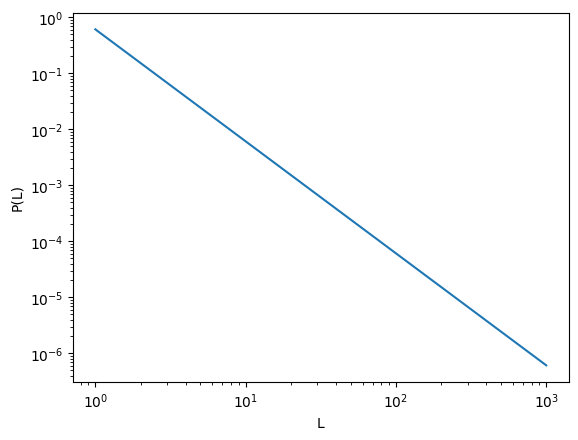

In [ ]:
plt.loglog(np.arange(1, 1000),
           pdf_powerlaw(L = np.arange(1,1000), beta = 1)
          )
plt.xlabel('L'); plt.ylabel('P(L)')

In [ ]:
#| export
def pdf_discrete_sample(pdf_func: object, # Function generating the pdf
                         num_samples: int, # Number of samples to create
                         **args_func # Arguments of the generating funcion
                        )-> np.array: # Samples
    ''' Samples discrete values from a given PDF'''
    P_L = pdf_func(**args_func)
    # Normalization check
    P_L = P_L/np.sum(P_L)
    
    return np.random.choice(np.arange(1, len(P_L)+1), p = P_L, size = num_samples)
    

<matplotlib.legend.Legend>

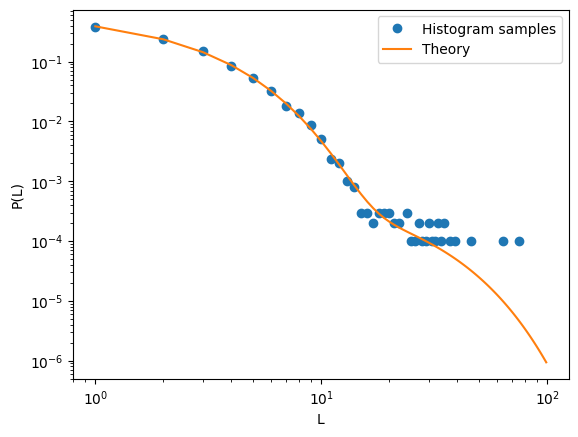

In [ ]:
samples = pdf_discrete_sample(pdf_func = pdf_multimode, 
                              num_samples=10000, 
                              L = np.arange(1, L_max), lambdas=lambdas, probs=probs)

counts = np.bincount(samples)[1:]

plt.loglog(np.arange(1, len(counts)+1),
           counts/counts.sum(), 'o', 
           label = 'Histogram samples')

plt.loglog(np.arange(1, L_max),
           pdf_multimode(L = np.arange(1, L_max), lambdas=lambdas, probs=probs),
           label = 'Theory'
          )
plt.xlabel('L'); plt.ylabel('P(L)'); plt.legend()

## Calculation of policy from step length PDF

In [ ]:
#|export
def get_policy_from_dist(n_max, # Maximum counter n_max for which the policy is calculated
                         func, # Function generating the pdf
                         renorm = True, # If true, we check whether the distribution has a boundary N, for which \sum_n=N^\infty  Pr(L=nd) = 0
                         **args_func # Arguments of the generating funcion (should have L_max as input parameter)
                        )-> np.array : # Policy at each counter value
    ''' Given a PDF of step lengths, calculates the corresponding policy'''
    
    policy = []
    
    if renorm:
        bound = np.copy(n_max + 1)
       
        for l in range(2, n_max):
            dist = func(L = np.arange(1, l, dtype=float), **args_func)
            if np.sum(dist) >= 1:
                bound = l-1  
                break
                
        for length in range(1, n_max+1):
            if length >= bound:
                policy.append(0)
            else:
                policy.append(1 - func(L = length, **args_func)  / (1-np.sum(func(L = np.arange(1, length, dtype=float), **args_func))))
                
    else:
        for length in range(1, n_max+1):
            policy.append(1 - func(L = length, **args_func) / (1-np.sum(func(L = np.arange(1, length, dtype=float), **args_func))))
            
    
    return policy

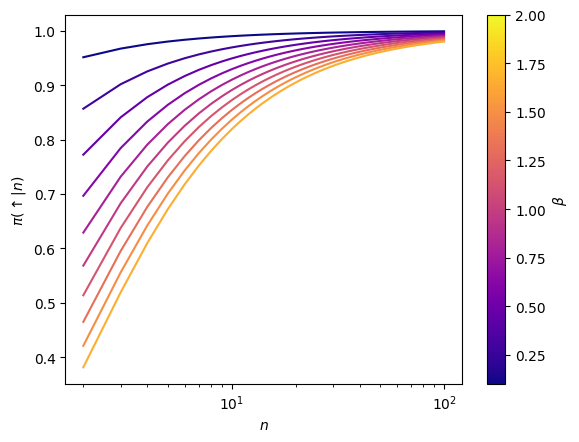

In [ ]:
L = 100
betas = np.linspace(0.1, 2, 10)
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))

fig, ax = plt.subplots()
for beta, color in zip(betas, colors):
    
    policy = get_policy_from_dist(n_max = L, 
                                  func = pdf_powerlaw,
                                  beta = beta)
    ax.plot(np.arange(2, L+1), policy[1:], c = color)


# Plot features    
plt.setp(ax, xlabel =r'$n$', ylabel = r'$\pi(\uparrow|n)$', xscale = 'log')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm= mcolors.Normalize(vmin=betas.min(), 
                                                                  vmax=betas.max()),
                                          cmap=plt.cm.plasma),
                    ax = ax)
cbar.set_label(r'$\beta$')

#| hide
# nbdev

In [ ]:
#| hide
from nbdev import nbdev_export ; nbdev_export()